In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy
from matplotlib import pyplot as plt
from IPython.display import clear_output
from matplotlib.colors import TABLEAU_COLORS

sys.path.append('../../..')
from uncertain.utils.data import Data
from uncertain.utils.training import train, run_study, load
from uncertain.utils.evaluation import test_vanilla, test_uncertain

from uncertain.implicit.base import MF, MLP
from uncertain.implicit.DoubleMF import DoubleMF

if os.path.isfile('data.pkl'):
    with open('data.pkl', 'rb') as f:
        data = pickle.load(f)
    print(f'Data prepared: {data.n_user} users, {data.n_item} items.')
    print(f'{len(data.train)} train, {len(data.val)} validation and {len(data.test)} test interactions.')
    data.batch_size = int(1e3)
else:
    data = pd.read_table('data.csv', sep=',', header=0)
    data.columns = ['user', 'item', 'score', 'timestamps']
    data = data.drop(columns='timestamps') # Trying randomly shuffled data
    data = Data(data, min_user_len=10, min_item_len=5, implicit=True)
    with open('data.pkl', 'wb') as f:
        pickle.dump(data, f, protocol=5)

data.item_support = data.item_support.astype(float)
data.user_support = data.user_support.astype(float)        

base_batch_size = 2048
trials = 1 ## 0 for eval only mode
patience = 2 ## Number of validation checks before ending training

ImportError: cannot import name 'DoubleMF' from 'uncertain.implicit.DoubleMF' (/home/vcoscrato/Documents/RecSys/MF/tests/Pointwise/Movielens/../../../uncertain/implicit/DoubleMF.py)

# Baselines

## MF

In [2]:
name = 'MF-BCE'
def init_model(**kwargs):
    return MF(data.n_user, data.n_item, embedding_dim=128, loss='BCE', **kwargs)

def objective(trial):
    
    # Parameter setup
    params = {'weight_decay': trial.suggest_float('wd', 1e-5, 1e-3, log=True),
              'n_negatives': trial.suggest_int('neg', 10, 80)}
    params_str = '-'.join(f'{key}={value}' for key, value in params.items())
    data.batch_size = int(base_batch_size / (params['n_negatives'] + 1))
    print(params, data.batch_size)

    # Train
    model = init_model(**params)
    MAP, path, train_likelihood = train(model, data, path='checkpoints/' + name, name=params_str, patience=patience)
    trial.set_user_attr('filename', path)
    trial.set_user_attr('mean_loss', train_likelihood)
    return MAP

study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1]
model = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_vanilla(model, data, max_k=10, name=name)

clear_output(wait=True)
best_runs

,number,value,datetime_start,datetime_complete,duration,params_neg,params_wd,user_attrs_filename,user_attrs_mean_loss,state
6,6,0.132925,2023-01-27 07:35:17.301395,2023-01-27 08:11:56.572396,0 days 00:36:39.271001,16,0.000797,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.910874,COMPLETE
5,5,0.130929,2023-01-27 06:50:53.963307,2023-01-27 07:35:17.300851,0 days 00:44:23.337544,29,0.000167,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.946747,COMPLETE
7,7,0.128924,2023-01-27 08:11:56.572939,2023-01-27 10:00:34.945258,0 days 01:48:38.372319,37,0.000093,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.957370,COMPLETE
9,9,0.128171,2023-01-27 11:25:13.925729,2023-01-27 12:07:27.836912,0 days 00:42:13.911183,20,0.000439,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.924189,COMPLETE
3,3,0.127527,2023-01-27 04:44:34.156614,2023-01-27 06:05:08.072166,0 days 01:20:33.915552,46,0.000050,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.965046,COMPLETE
1,1,0.125536,2023-01-27 01:37:41.308798,2023-01-27 02:51:34.918712,0 days 01:13:53.609914,56,0.000021,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.969032,COMPLETE
4,4,0.124704,2023-01-27 06:05:08.072810,2023-01-27 06:50:53.962706,0 days 00:45:45.889896,30,0.000017,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.950669,COMPLETE
0,0,0.120846,2023-01-26 22:59:57.844395,2023-01-27 01:37:41.308202,0 days 02:37:43.463807,52,0.000313,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.967003,COMPLETE
8,8,0.120153,2023-01-27 10:00:34.947654,2023-01-27 11:25:13.924813,0 days 01:24:38.977159,71,0.000026,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.974081,COMPLETE
2,2,0.119252,2023-01-27 02:51:34.919369,2023-01-27 04:44:34.156044,0 days 01:52:59.236675,77,0.000029,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.977996,COMPLETE


In [3]:
name = 'MF-BPR'
def init_model(**kwargs):
    return MF(data.n_user, data.n_item, embedding_dim=128, loss='BPR', **kwargs)

def objective(trial):
    
    # Parameter setup
    params = {'weight_decay': trial.suggest_float('wd', 1e-4, 1e-2, log=True)}
    params_str = '-'.join(f'{key}={value}' for key, value in params.items())
    data.batch_size = int(base_batch_size / 2)
    print(params, data.batch_size)

    # Train
    model = init_model(**params)
    MAP, path, train_likelihood = train(model, data, path='checkpoints/' + name, name=params_str, patience=patience)
    trial.set_user_attr('filename', path)
    trial.set_user_attr('mean_loss', train_likelihood)
    return MAP

study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1]
model = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_vanilla(model, data, max_k=10, name=name)

clear_output(wait=True)
best_runs

,number,value,datetime_start,datetime_complete,duration,params_wd,user_attrs_filename,user_attrs_mean_loss,state
0,0,0.117818,2023-01-28 03:46:49.123617,2023-01-28 04:01:17.257630,0 days 00:14:28.134013,0.001650,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.840756,COMPLETE
7,7,0.115777,2023-01-28 05:05:51.851312,2023-01-28 05:17:57.252100,0 days 00:12:05.400788,0.001513,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.836901,COMPLETE
6,6,0.114439,2023-01-28 04:54:21.225136,2023-01-28 05:05:51.850812,0 days 00:11:30.625676,0.001202,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.836859,COMPLETE
1,1,0.114013,2023-01-28 04:01:17.258130,2023-01-28 04:14:15.828241,0 days 00:12:58.570111,0.000959,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.854080,COMPLETE
8,8,0.109275,2023-01-28 05:17:57.252730,2023-01-28 05:29:24.037332,0 days 00:11:26.784602,0.000363,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.843731,COMPLETE
2,2,0.109159,2023-01-28 04:14:15.828890,2023-01-28 04:25:11.227569,0 days 00:10:55.398679,0.000246,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.839803,COMPLETE
5,5,0.106716,2023-01-28 04:44:52.854462,2023-01-28 04:54:21.224527,0 days 00:09:28.370065,0.000270,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.822336,COMPLETE
3,3,0.105889,2023-01-28 04:25:11.228172,2023-01-28 04:34:59.628256,0 days 00:09:48.400084,0.000369,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.837636,COMPLETE
4,4,0.105623,2023-01-28 04:34:59.628986,2023-01-28 04:44:52.853943,0 days 00:09:53.224957,0.007650,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.793506,COMPLETE
9,9,0.105103,2023-01-28 05:29:24.037932,2023-01-28 05:37:40.084980,0 days 00:08:16.047048,0.007044,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.792337,COMPLETE


In [30]:
name = 'MF-MSE'
def init_model(**kwargs):
    return MF(data.n_user, data.n_item, embedding_dim=128, loss='MSE', **kwargs)

def objective(trial):
    
    # Parameter setup
    params = {'weight_decay': trial.suggest_float('wd', 1e-4, 1e-2, log=True),
              'n_negatives': trial.suggest_int('neg', 1, 20)}
    params_str = '-'.join(f'{key}={value}' for key, value in params.items())
    data.batch_size = int(base_batch_size / (params['n_negatives'] + 1))
    print(params, data.batch_size)

    # Train
    model = init_model(**params)
    MAP, path, train_likelihood = train(model, data, path='checkpoints/' + name, name=params_str, patience=patience)
    trial.set_user_attr('filename', path)
    trial.set_user_attr('mean_loss', train_likelihood)
    return MAP

study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1]
model = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_vanilla(model, data, max_k=10, name=name)

clear_output(wait=True)
best_runs

,number,value,datetime_start,datetime_complete,duration,params_neg,params_wd,user_attrs_filename,user_attrs_mean_loss,state
5,5,0.137550,2023-01-27 15:52:11.066001,2023-01-27 16:28:30.976381,0 days 00:36:19.910380,12,0.000982,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.978448,COMPLETE
2,2,0.137115,2023-01-27 14:50:40.840313,2023-01-27 15:10:11.008997,0 days 00:19:30.168684,11,0.001513,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.976986,COMPLETE
1,1,0.136060,2023-01-27 14:34:12.379048,2023-01-27 14:50:40.839611,0 days 00:16:28.460563,10,0.003492,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.973453,COMPLETE
8,8,0.129888,2023-01-27 17:15:26.414633,2023-01-27 17:40:17.973945,0 days 00:24:51.559312,12,0.000456,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.977651,COMPLETE
3,3,0.129733,2023-01-27 15:10:11.009849,2023-01-27 15:35:45.207261,0 days 00:25:34.197412,20,0.000292,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.984435,COMPLETE
0,0,0.127278,2023-01-27 14:18:51.027434,2023-01-27 14:34:12.378508,0 days 00:15:21.351074,10,0.000469,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.974685,COMPLETE
7,7,0.124955,2023-01-27 16:42:49.776523,2023-01-27 17:15:26.413534,0 days 00:32:36.637011,9,0.000391,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.975261,COMPLETE
6,6,0.119315,2023-01-27 16:28:30.977593,2023-01-27 16:42:49.775537,0 days 00:14:18.797944,1,0.008787,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.943020,COMPLETE
4,4,0.105135,2023-01-27 15:35:45.207931,2023-01-27 15:52:11.065323,0 days 00:16:25.857392,3,0.000168,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.957297,COMPLETE
9,9,0.082676,2023-01-27 17:40:17.974833,2023-01-27 18:00:00.462201,0 days 00:19:42.487368,16,0.009312,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.979515,COMPLETE


## MLP

In [24]:
name = 'MLP-BCE'
def init_model(**kwargs):
    return MLP(data.n_user, data.n_item, embedding_dim=128, loss='BCE', **kwargs)

def objective(trial):
    
    # Parameter setup
    params = {'dropout': trial.suggest_float('dropout', 0, 0.2),
              'n_negatives': trial.suggest_int('neg', 1, 20)}
    params_str = '-'.join(f'{key}={value}' for key, value in params.items())
    data.batch_size = int(base_batch_size / (params['n_negatives'] + 1))
    print(params, data.batch_size)

    # Train
    model = init_model(**params)
    MAP, path, train_likelihood = train(model, data, path='checkpoints/' + name, name=params_str, patience=patience)
    trial.set_user_attr('filename', path)
    trial.set_user_attr('mean_loss', train_likelihood)
    return MAP

study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
model = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_vanilla(model, data, max_k=10, name=name)

clear_output(wait=True)
print(results['MAP'])
best_runs

[0.3405629  0.42077816 0.4468957  0.45544976 0.45588532 0.4537752
 0.45033693 0.444985   0.43996194 0.43384206]


,number,value,datetime_start,datetime_complete,duration,params_dropout,params_neg,user_attrs_filename,user_attrs_mean_loss,state
9,9,0.118966,2023-04-12 17:10:39.322106,2023-04-12 17:48:47.119862,0 days 00:38:07.797756,0.111993,17,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.918314,COMPLETE
7,7,0.118465,2023-04-12 16:29:49.339916,2023-04-12 16:52:31.107141,0 days 00:22:41.767225,0.041409,18,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.918602,COMPLETE
2,2,0.116720,2023-04-12 15:11:24.012492,2023-04-12 15:38:07.637210,0 days 00:26:43.624718,0.154908,15,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.908222,COMPLETE
0,0,0.113589,2023-04-12 12:16:33.304811,2023-04-12 12:37:45.091050,0 days 00:21:11.786239,0.122131,9,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.867336,COMPLETE
3,3,0.109631,2023-04-12 15:38:07.637941,2023-04-12 15:54:38.381687,0 days 00:16:30.743746,0.126202,6,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.841795,COMPLETE


In [25]:
name = 'MLP-BPR'
def init_model(**kwargs):
    return MLP(data.n_user, data.n_item, embedding_dim=128, loss='BPR', **kwargs)

def objective(trial):
    
    # Parameter setup
    params = {'dropout': trial.suggest_float('dropout', 0, 0.2)}
    params_str = '-'.join(f'{key}={value}' for key, value in params.items())
    data.batch_size = int(base_batch_size / 2)
    print(params, data.batch_size)

    # Train
    model = init_model(**params)
    MAP, path, train_likelihood = train(model, data, path='checkpoints/' + name, name=params_str, patience=patience)
    trial.set_user_attr('filename', path)
    trial.set_user_attr('mean_loss', train_likelihood)
    return MAP

study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
model = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_vanilla(model, data, max_k=10, name=name)

clear_output(wait=True)
print(results['MAP'])
best_runs

[0.32533112 0.39395696 0.41639072 0.42168874 0.42230844 0.41977856
 0.41706693 0.41276622 0.40796965 0.40378132]


,number,value,datetime_start,datetime_complete,duration,params_dropout,user_attrs_filename,user_attrs_mean_loss,state
3,3,0.094757,2023-04-12 17:55:38.318503,2023-04-12 18:09:45.714643,0 days 00:14:07.396140,0.112443,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.825016,COMPLETE
5,5,0.074880,2023-04-12 18:12:51.292978,2023-04-12 18:19:54.286127,0 days 00:07:02.993149,0.004548,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.787842,COMPLETE
2,2,0.062569,2023-04-12 17:52:29.517900,2023-04-12 17:55:38.317888,0 days 00:03:08.799988,0.070336,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.740216,COMPLETE
9,9,0.062239,2023-04-12 18:27:44.301936,2023-04-12 18:30:03.753358,0 days 00:02:19.451422,0.193639,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.742024,COMPLETE
4,4,0.061466,2023-04-12 18:09:45.715473,2023-04-12 18:12:51.292322,0 days 00:03:05.576849,0.089290,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.736551,COMPLETE


In [26]:
name = 'MLP-MSE'
def init_model(**kwargs):
    return MLP(data.n_user, data.n_item, loss='MSE', **kwargs)

def objective(trial):
    
    # Parameter setup
    params = {'dropout': trial.suggest_float('dropout', 0, 0.2),
              'n_negatives': trial.suggest_int('neg', 1, 20)}
    params_str = '-'.join(f'{key}={value}' for key, value in params.items())
    data.batch_size = int(base_batch_size / (params['n_negatives'] + 1))
    print(params, data.batch_size)

    # Train
    model = init_model(**params)
    MAP, path, train_likelihood = train(model, data, path='checkpoints/' + name, name=params_str, patience=patience)
    trial.set_user_attr('filename', path)
    trial.set_user_attr('mean_loss', train_likelihood)
    return MAP

study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
model = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_vanilla(model, data, max_k=10, name=name)

clear_output(wait=True)
print(results['MAP'])
best_runs

[0.3571192  0.4437914  0.4708057  0.47827446 0.4786773  0.47543877
 0.47089165 0.4659963  0.46052107 0.45441934]


,number,value,datetime_start,datetime_complete,duration,params_dropout,params_neg,user_attrs_filename,user_attrs_mean_loss,state
6,6,0.121772,2023-04-12 20:36:24.558714,2023-04-12 21:06:01.145532,0 days 00:29:36.586818,0.047904,18,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.983109,COMPLETE
3,3,0.120468,2023-04-12 19:11:24.506378,2023-04-12 19:40:21.951165,0 days 00:28:57.444787,0.104029,19,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.983289,COMPLETE
4,4,0.120377,2023-04-12 19:40:21.951737,2023-04-12 20:09:17.235722,0 days 00:28:55.283985,0.070603,19,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.983804,COMPLETE
9,9,0.120206,2023-04-12 21:27:46.678042,2023-04-12 21:51:33.074218,0 days 00:23:46.396176,0.040320,13,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.978171,COMPLETE
5,5,0.118631,2023-04-12 20:09:17.236352,2023-04-12 20:36:24.557603,0 days 00:27:07.321251,0.126123,15,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.980930,COMPLETE


## Results

MF-MSE     0.829870
MF-BCE     0.861309
MF-BPR     0.859335
MLP-MSE    0.851103
MLP-BCE    0.859512
MLP-BPR    0.849351
Name: FCP, dtype: float64


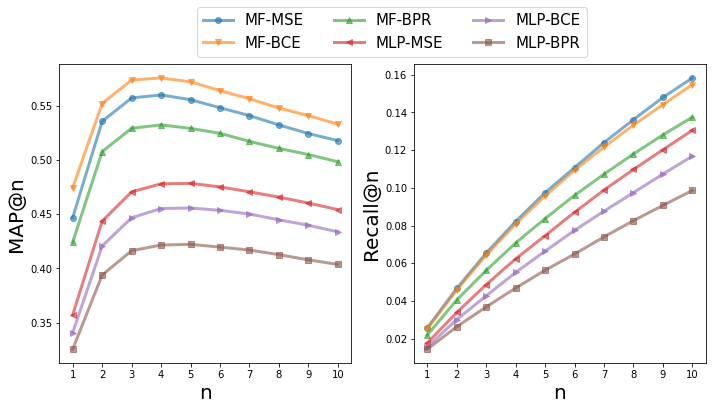

In [28]:
# Load results
results = {}
for key in os.listdir('results'):
    results[key.replace('.pkl', '').replace('_', ' ')] = pickle.load(open(os.path.join('results', key), 'rb'))
order = ['MF-MSE', 'MF-BCE', 'MF-BPR',
         'MLP-MSE', 'MLP-BCE', 'MLP-BPR']
results = pd.DataFrame([results[key] for key in order], index=order)

# Plot aestetics
colors = [c for c in list(TABLEAU_COLORS)]
colors = {k:c for k, c in zip(results.index, colors)}
lines = ['o', 'v', '^', '<', '>', 's', 'p', '+', 'x', '*', 'p']
lines = {k: '-' + l for k, l, in zip(results.index, lines)}

# Results
print(results['FCP'])

## Top-K accuracy metrics
f, ax = plt.subplots(figsize=(10, 5), ncols=2)
for index, row in results.iterrows():
    ax[0].plot(np.arange(1, 11), row['MAP'], lines[index], color=colors[index], label=index, linewidth=3, alpha=0.6)
    ax[1].plot(np.arange(1, 11), row['Recall'], lines[index], color=colors[index], label=index, linewidth=3, alpha=0.6)
ax[0].set_xticks(np.arange(1, 11))
ax[0].set_xlabel('n', fontsize=20)
ax[0].set_ylabel('MAP@n', fontsize=20)
ax[1].set_xticks(np.arange(1, 11))
ax[1].set_xlabel('n', fontsize=20)
ax[1].set_ylabel('Recall@n', fontsize=20)
handles, labels = ax[0].get_legend_handles_labels()
f.legend(handles, labels, fontsize=15, ncol=3, bbox_to_anchor=(0.83, 1.15))
f.tight_layout()
f.savefig('plots/baselines.pdf', bbox_inches='tight')

## Base for sequential GBR and GPR

In [1]:
name = 'MF-Pointwise'
def init_model(**kwargs):
    return MF(data.n_user, data.n_item, embedding_dim=128, loss='Pointwise', **kwargs)

def objective(trial):
    
    # Parameter setup
    params = {'weight_decay': trial.suggest_float('wd', 1e-4, 1e-2, log=True),
              'n_negatives': trial.suggest_int('neg', 1, 20)}
    params_str = '-'.join(f'{key}={value}' for key, value in params.items())
    data.batch_size = int(base_batch_size / (params['n_negatives'] + 1))
    print(params, data.batch_size)

    # Train
    model = init_model(**params)
    MAP, path, train_likelihood = train(model, data, path='checkpoints/' + name, name=params_str, patience=patience)
    trial.set_user_attr('filename', path)
    trial.set_user_attr('mean_loss', train_likelihood)
    return MAP

study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1]
mfpoint = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_vanilla(mfpoint, data, max_k=10, name=name)

clear_output(wait=True)
best_runs

NameError: name 'run_study' is not defined

In [32]:
name = 'MF-Pairwise'
def init_model(**kwargs):
    return MF(data.n_user, data.n_item, embedding_dim=128, loss='Pairwise', **kwargs)

def objective(trial):
    
    # Parameter setup
    params = {'weight_decay': trial.suggest_float('wd', 1e-4, 1e-2, log=True)}
    params_str = '-'.join(f'{key}={value}' for key, value in params.items())
    data.batch_size = int(base_batch_size / 2)
    print(params, data.batch_size)

    # Train
    model = init_model(**params)
    MAP, path, train_likelihood = train(model, data, path='checkpoints/' + name, name=params_str, patience=patience)
    trial.set_user_attr('filename', path)
    trial.set_user_attr('mean_loss', train_likelihood)
    return MAP

study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1]
mfpair = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_vanilla(mfpair, data, max_k=10, name=name)

clear_output(wait=True)
best_runs

,number,value,datetime_start,datetime_complete,duration,params_wd,user_attrs_filename,user_attrs_mean_loss,state
7,7,0.118565,2023-01-27 23:32:19.476182,2023-01-27 23:57:53.786656,0 days 00:25:34.310474,0.005911,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.822745,COMPLETE
4,4,0.117796,2023-01-27 22:36:12.584062,2023-01-27 22:59:18.846765,0 days 00:23:06.262703,0.001275,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.864753,COMPLETE
3,3,0.114444,2023-01-27 22:26:12.229563,2023-01-27 22:36:12.583550,0 days 00:10:00.353987,0.003808,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.823914,COMPLETE
9,9,0.112663,2023-01-28 00:18:29.923827,2023-01-28 00:29:43.320941,0 days 00:11:13.397114,0.004449,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.821147,COMPLETE
5,5,0.110323,2023-01-27 22:59:18.847770,2023-01-27 23:17:31.008971,0 days 00:18:12.161201,0.008207,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.802251,COMPLETE
8,8,0.109622,2023-01-27 23:57:53.787562,2023-01-28 00:18:29.923261,0 days 00:20:36.135699,0.000183,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.863125,COMPLETE
1,1,0.108452,2023-01-27 21:57:57.163781,2023-01-27 22:11:24.064462,0 days 00:13:26.900681,0.000132,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.867347,COMPLETE
2,2,0.107647,2023-01-27 22:11:24.064962,2023-01-27 22:26:12.228988,0 days 00:14:48.164026,0.000159,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.872469,COMPLETE
0,0,0.107423,2023-01-27 21:49:08.626666,2023-01-27 21:57:57.163288,0 days 00:08:48.536622,0.008629,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.796969,COMPLETE
6,6,0.101408,2023-01-27 23:17:31.010118,2023-01-27 23:32:19.475020,0 days 00:14:48.464902,0.000108,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.832416,COMPLETE


# Uncertainty MF models

,number,value,datetime_start,datetime_complete,duration,params_gamma,params_neg,params_ratio,user_attrs_filename,user_attrs_mean_loss,state
0,0,0.137679,2023-01-30 11:46:08.163323,2023-01-30 12:11:34.885531,0 days 00:25:26.722208,0.002245,9,0.2,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,15.951998,COMPLETE
1,1,0.137604,2023-01-30 12:11:34.886269,2023-01-30 12:33:27.563491,0 days 00:21:52.677222,0.000516,10,0.3,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,20.179342,COMPLETE


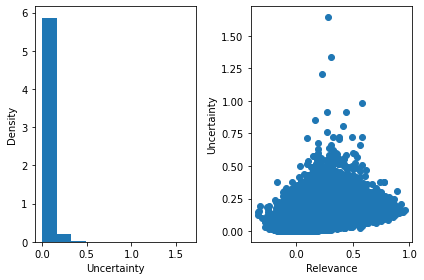

In [35]:
name = 'AUR'
def init_model(**kwargs):
    return AUR(baseline=mfmse, embedding_dim=128, beta=1/2, **kwargs)

def objective(trial):
    
    # Parameter setup
    params = {'n_negatives': trial.suggest_int('neg', 2, 20),
              'gamma': trial.suggest_float('gamma', 1e-5, 1e-2, log=True),
              'ratio': trial.suggest_float('ratio', 0.2, 0.8, step=0.1)}
    params_str = '-'.join(f'{key}={value}' for key, value in params.items())
    data.batch_size = int(base_batch_size / (params['n_negatives'] + 1))
    print(params, data.batch_size)

    # Train
    model = init_model(**params)
    recall, path, train_likelihood = train(model, data, path='checkpoints/' + name, name=params_str, patience=patience)
    trial.set_user_attr('filename', path)
    trial.set_user_attr('mean_loss', train_likelihood)
    return recall

study = run_study(name, objective, n_trials=2)
best_runs = study.trials_dataframe().sort_values('value')[::-1]
model = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_uncertain(model, data, max_k=10, name=name)

clear_output(wait=True)
best_runs

,number,value,datetime_start,datetime_complete,duration,params_gamma,params_neg,user_attrs_filename,user_attrs_mean_loss,state
1,1,0.123609,2023-01-30 14:30:56.800888,2023-01-30 14:42:20.274056,0 days 00:11:23.473168,0.000071,13,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.903016,COMPLETE
0,0,0.118670,2023-01-30 14:19:24.870431,2023-01-30 14:30:56.799999,0 days 00:11:31.929568,0.000034,14,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.903086,COMPLETE
3,3,0.105394,2023-01-30 14:48:03.059669,2023-01-30 14:54:04.435539,0 days 00:06:01.375870,0.003956,16,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.934442,COMPLETE
2,2,0.013619,2023-01-30 14:44:55.825979,2023-01-30 14:48:03.059014,0 days 00:03:07.233035,0.047359,16,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,-inf,COMPLETE


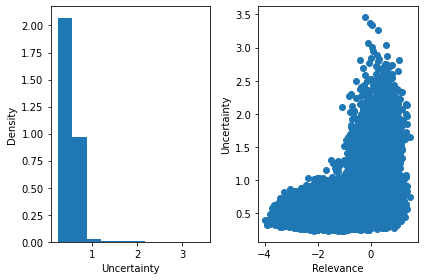

In [5]:
name = 'Pointwise'
def init_model(**kwargs):
    return Pointwise(baseline=mfpoint, embedding_dim=128, **kwargs)

def objective(trial):
    
    # Parameter setup
    params = {'n_negatives': trial.suggest_int('neg', 2, 20),
              'gamma': trial.suggest_float('gamma', 1e-4, 1e-1, log=True)}
    params_str = '-'.join(f'{key}={value}' for key, value in params.items())
    data.batch_size = int(base_batch_size / (params['n_negatives'] + 1))
    print(params, data.batch_size)

    # Train
    model = init_model(**params)
    recall, path, train_likelihood = train(model, data, path='checkpoints/' + name, name=params_str, patience=patience)
    trial.set_user_attr('filename', path)
    trial.set_user_attr('mean_loss', train_likelihood)
    return recall

study = run_study(name, objective, n_trials=2)
best_runs = study.trials_dataframe().sort_values('value')[::-1]
model = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_uncertain(model, data, max_k=10, name=name)

clear_output(wait=True)
best_runs

,number,value,datetime_start,datetime_complete,duration,params_gamma,params_neg,params_ratio,user_attrs_filename,user_attrs_mean_loss,state
4,4,0.130263,2023-01-30 16:02:24.117698,2023-01-30 16:10:01.379081,0 days 00:07:37.261383,0.005632,3,0.2,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.812846,COMPLETE
1,1,0.130035,2023-01-30 15:32:43.803929,2023-01-30 15:37:15.618219,0 days 00:04:31.814290,0.000224,4,0.4,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.812748,COMPLETE
0,0,0.123177,2023-01-30 15:26:30.989463,2023-01-30 15:32:43.803041,0 days 00:06:12.813578,0.000461,12,0.3,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.902726,COMPLETE
2,2,0.013619,2023-01-30 15:53:30.607161,2023-01-30 15:56:27.781228,0 days 00:02:57.174067,0.010734,19,0.3,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,-inf,COMPLETE
3,3,-inf,2023-01-30 15:57:18.930089,2023-01-30 15:57:22.586509,0 days 00:00:03.656420,0.015227,20,0.2,,-inf,COMPLETE


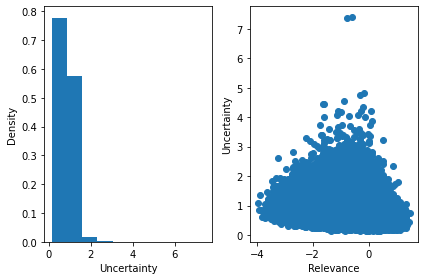

In [10]:
name = 'Pointwise-ratio'
def init_model(**kwargs):
    return Pointwise(baseline=mfpoint, embedding_dim=128, **kwargs)

def objective(trial):
    
    # Parameter setup
    params = {'n_negatives': trial.suggest_int('neg', 2, 10),
              'gamma': trial.suggest_float('gamma', 1e-4, 1e-1, log=True),
              'ratio': trial.suggest_float('ratio', 0.2, 0.4, step=0.1)}
    params_str = '-'.join(f'{key}={value}' for key, value in params.items())
    data.batch_size = int(base_batch_size / (params['n_negatives'] + 1))
    print(params, data.batch_size)

    # Train
    model = init_model(**params)
    recall, path, train_likelihood = train(model, data, path='checkpoints/' + name, name=params_str, patience=patience)
    trial.set_user_attr('filename', path)
    trial.set_user_attr('mean_loss', train_likelihood)
    return recall

study = run_study(name, objective, n_trials=1)
best_runs = study.trials_dataframe().sort_values('value')[::-1]
model = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_uncertain(model, data, max_k=10, name=name)

clear_output(wait=True)
best_runs

,number,value,datetime_start,datetime_complete,duration,params_gamma,user_attrs_filename,user_attrs_mean_loss,state
1,1,0.068732,2023-01-15 03:21:10.123230,2023-01-15 03:21:59.679932,0 days 00:00:49.556702,0.000109,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.895412,COMPLETE
2,2,0.067683,2023-01-15 03:21:59.680475,2023-01-15 03:22:45.175794,0 days 00:00:45.495319,0.000105,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.891192,COMPLETE
8,8,0.067564,2023-01-15 03:28:19.163444,2023-01-15 03:29:08.415579,0 days 00:00:49.252135,0.000797,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.896435,COMPLETE
0,0,0.066280,2023-01-15 03:20:05.558341,2023-01-15 03:21:10.122564,0 days 00:01:04.564223,0.000023,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.895100,COMPLETE
4,4,0.066186,2023-01-15 03:23:53.091179,2023-01-15 03:25:14.301691,0 days 00:01:21.210512,0.003296,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.898293,COMPLETE
9,9,0.065767,2023-01-15 03:29:08.416199,2023-01-15 03:30:15.740439,0 days 00:01:07.324240,0.005463,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.898822,COMPLETE
6,6,0.065426,2023-01-15 03:26:41.558256,2023-01-15 03:27:30.734247,0 days 00:00:49.175991,0.000162,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.899582,COMPLETE
5,5,0.064834,2023-01-15 03:25:14.302491,2023-01-15 03:26:41.557623,0 days 00:01:27.255132,0.000059,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.893697,COMPLETE
7,7,0.064244,2023-01-15 03:27:30.734916,2023-01-15 03:28:19.162818,0 days 00:00:48.427902,0.004621,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.901298,COMPLETE
3,3,0.063537,2023-01-15 03:22:45.176508,2023-01-15 03:23:53.090577,0 days 00:01:07.914069,0.001173,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.893428,COMPLETE


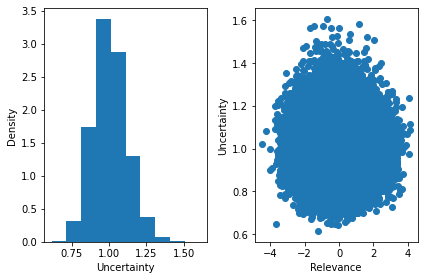

In [12]:
name = 'Pairwise'
def init_model(**kwargs):
    return Pairwise(baseline=mfpair, embedding_dim=128, **kwargs)

def objective(trial):
    
    # Parameter setup
    params = {'gamma': trial.suggest_float('gamma', 1e-5, 1e-2, log=True)}
    params_str = '-'.join(f'{key}={value}' for key, value in params.items())
    data.batch_size = int(base_batch_size / 2)
    print(params, data.batch_size)

    # Train
    model = init_model(**params)
    recall, path, train_likelihood = train(model, data, path='checkpoints/' + name, name=params_str, patience=patience)
    trial.set_user_attr('filename', path)
    trial.set_user_attr('mean_loss', train_likelihood)
    return recall

study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1]
model = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_uncertain(model, data, max_k=10, name=name)

clear_output(wait=True)
best_runs

# Uncertainty MF models

,number,value,datetime_start,datetime_complete,duration,params_gamma,params_neg,params_ratio,user_attrs_filename,user_attrs_mean_loss,state
6,6,0.100954,2023-01-14 19:20:00.381166,2023-01-14 19:52:36.752267,0 days 00:32:36.371101,0.000074,37,0.2,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,41.172779,COMPLETE
2,2,0.100241,2023-01-14 16:44:34.132587,2023-01-14 18:08:20.172892,0 days 01:23:46.040305,0.000053,81,0.3,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,48.875999,COMPLETE
4,4,0.100023,2023-01-14 18:28:35.379663,2023-01-14 19:02:20.370390,0 days 00:33:44.990727,0.000051,82,0.3,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,37.791054,COMPLETE
0,0,0.099624,2023-01-14 15:04:32.615560,2023-01-14 15:48:03.568856,0 days 00:43:30.953296,0.000204,95,0.2,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,31.508522,COMPLETE
5,5,0.099620,2023-01-14 19:02:20.371128,2023-01-14 19:20:00.379133,0 days 00:17:40.008005,0.000273,20,0.2,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,37.363949,COMPLETE
8,8,0.098267,2023-01-14 21:37:56.983846,2023-01-14 21:53:53.603933,0 days 00:15:56.620087,0.001321,38,0.4,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,30.229002,COMPLETE
1,1,0.094715,2023-01-14 15:48:03.570203,2023-01-14 16:44:34.131910,0 days 00:56:30.561707,0.002621,65,0.7,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,34.109360,COMPLETE
9,9,0.093078,2023-01-14 21:53:53.604618,2023-01-14 22:42:17.954782,0 days 00:48:24.350164,0.000609,61,0.7,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,39.886951,COMPLETE
7,7,0.091874,2023-01-14 19:52:36.753041,2023-01-14 21:37:56.983059,0 days 01:45:20.230018,0.000032,90,0.8,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,58.157131,COMPLETE
3,3,0.089528,2023-01-14 18:08:20.174213,2023-01-14 18:28:35.378919,0 days 00:20:15.204706,0.003571,28,0.7,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,23.394882,COMPLETE


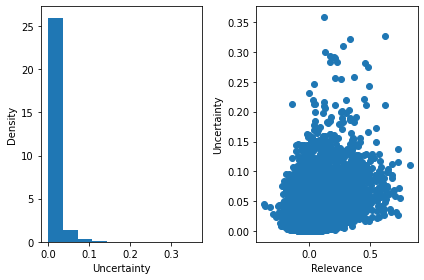

In [3]:
name = 'AUR'
def init_model(**kwargs):
    return AUR(baseline=mfmse, embedding_dim=128, beta=1/2, **kwargs)

def objective(trial):
    
    # Parameter setup
    params = {'n_negatives': trial.suggest_int('neg', 2, 20),
              'gamma': trial.suggest_float('gamma', 1e-4, 1e-1, log=True),
              'ratio': trial.suggest_float('ratio', 0.2, 0.8, step=0.1)}
    params_str = '-'.join(f'{key}={value}' for key, value in params.items())
    data.batch_size = int(base_batch_size / (params['n_negatives'] + 1))
    print(params, data.batch_size)

    # Train
    model = init_model(**params)
    recall, path, train_likelihood = train(model, data, path='checkpoints/' + name, name=params_str, patience=patience)
    trial.set_user_attr('filename', path)
    trial.set_user_attr('mean_loss', train_likelihood)
    return recall

study = run_study(name, objective, n_trials=0)
best_runs = study.trials_dataframe().sort_values('value')[::-1]
model = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_uncertain(model, data, max_k=10, name=name)

clear_output(wait=True)
best_runs

,number,value,datetime_start,datetime_complete,duration,params_gamma,params_neg,params_ratio,user_attrs_filename,user_attrs_mean_loss,state
1,1,0.090593,2023-01-17 13:33:33.093673,2023-01-17 13:45:38.639744,0 days 00:12:05.546071,0.000025,36,0.4,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.968607,COMPLETE
0,0,0.089703,2023-01-17 13:25:16.583609,2023-01-17 13:33:33.092830,0 days 00:08:16.509221,0.002215,33,0.4,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.975287,COMPLETE


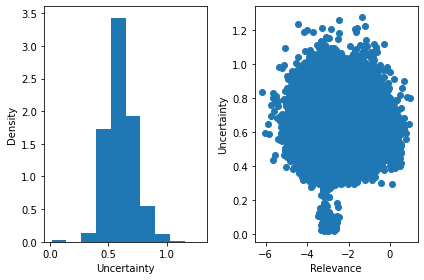

In [3]:
name = 'Pointwise-AURratio'
def init_model(**kwargs):
    return Pointwise(baseline=mfpoint, embedding_dim=128, **kwargs)

def objective(trial):
    
    # Parameter setup
    params = {'n_negatives': trial.suggest_int('neg', 20, 100),
              'gamma': trial.suggest_float('gamma', 1e-5, 1e-2, log=True),
              'ratio': trial.suggest_float('ratio', 0.2, 0.4, step=0.1)}
    params_str = '-'.join(f'{key}={value}' for key, value in params.items())
    data.batch_size = int(base_batch_size / (params['n_negatives'] + 1))
    print(params, data.batch_size)

    # Train
    model = init_model(**params)
    recall, path, train_likelihood = train(model, data, path='checkpoints/' + name, name=params_str, patience=patience)
    trial.set_user_attr('filename', path)
    trial.set_user_attr('mean_loss', train_likelihood)
    return recall

study = run_study(name, objective, n_trials=2)
best_runs = study.trials_dataframe().sort_values('value')[::-1]
model = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_uncertain(model, data, max_k=10, name=name)

clear_output(wait=True)
best_runs

,number,value,datetime_start,datetime_complete,duration,params_gamma,params_neg,user_attrs_filename,user_attrs_mean_loss,state
0,0,0.090775,2023-01-15 01:09:38.570971,2023-01-15 01:15:34.765271,0 days 00:05:56.194300,0.000096,21,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.959894,COMPLETE
4,4,0.089756,2023-01-15 01:59:23.063881,2023-01-15 02:20:15.369292,0 days 00:20:52.305411,0.000022,90,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.987010,COMPLETE
8,8,0.089417,2023-01-15 02:52:08.692978,2023-01-15 02:59:12.616939,0 days 00:07:03.923961,0.000320,30,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.966372,COMPLETE
2,2,0.089387,2023-01-15 01:29:37.586132,2023-01-15 01:46:48.538601,0 days 00:17:10.952469,0.000062,77,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.983896,COMPLETE
6,6,0.089239,2023-01-15 02:34:41.830539,2023-01-15 02:44:19.631420,0 days 00:09:37.800881,0.000070,30,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.965378,COMPLETE
5,5,0.089151,2023-01-15 02:20:15.369988,2023-01-15 02:34:41.829915,0 days 00:14:26.459927,0.000070,63,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.984171,COMPLETE
7,7,0.089108,2023-01-15 02:44:19.631988,2023-01-15 02:52:08.692351,0 days 00:07:49.060363,0.007248,48,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,1.003462,COMPLETE
9,9,0.089049,2023-01-15 02:59:12.617545,2023-01-15 03:19:44.512136,0 days 00:20:31.894591,0.000054,89,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.985813,COMPLETE
1,1,0.088350,2023-01-15 01:15:34.765899,2023-01-15 01:29:37.585589,0 days 00:14:02.819690,0.000517,94,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.990678,COMPLETE
3,3,0.088312,2023-01-15 01:46:48.539568,2023-01-15 01:59:23.063197,0 days 00:12:34.523629,0.000854,82,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.990814,COMPLETE


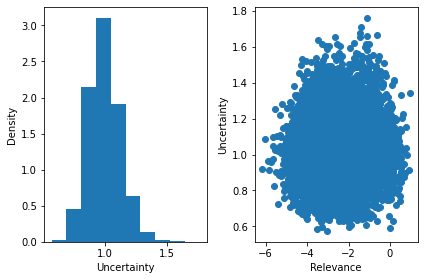

In [3]:
name = 'Pointwise'
def init_model(**kwargs):
    return Pointwise(baseline=mfpoint, embedding_dim=128, **kwargs)

def objective(trial):
    
    # Parameter setup
    params = {'n_negatives': trial.suggest_int('neg', 20, 100),
              'gamma': trial.suggest_float('gamma', 1e-5, 1e-2, log=True)}
    params_str = '-'.join(f'{key}={value}' for key, value in params.items())
    data.batch_size = int(base_batch_size / (params['n_negatives'] + 1))
    print(params, data.batch_size)

    # Train
    model = init_model(**params)
    recall, path, train_likelihood = train(model, data, path='checkpoints/' + name, name=params_str, patience=patience)
    trial.set_user_attr('filename', path)
    trial.set_user_attr('mean_loss', train_likelihood)
    return recall

study = run_study(name, objective, n_trials=0)
best_runs = study.trials_dataframe().sort_values('value')[::-1]
model = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_uncertain(model, data, max_k=10, name=name)

clear_output(wait=True)
best_runs

,number,value,datetime_start,datetime_complete,duration,params_gamma,user_attrs_filename,user_attrs_mean_loss,state
1,1,0.068732,2023-01-15 03:21:10.123230,2023-01-15 03:21:59.679932,0 days 00:00:49.556702,0.000109,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.895412,COMPLETE
2,2,0.067683,2023-01-15 03:21:59.680475,2023-01-15 03:22:45.175794,0 days 00:00:45.495319,0.000105,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.891192,COMPLETE
8,8,0.067564,2023-01-15 03:28:19.163444,2023-01-15 03:29:08.415579,0 days 00:00:49.252135,0.000797,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.896435,COMPLETE
0,0,0.066280,2023-01-15 03:20:05.558341,2023-01-15 03:21:10.122564,0 days 00:01:04.564223,0.000023,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.895100,COMPLETE
4,4,0.066186,2023-01-15 03:23:53.091179,2023-01-15 03:25:14.301691,0 days 00:01:21.210512,0.003296,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.898293,COMPLETE
9,9,0.065767,2023-01-15 03:29:08.416199,2023-01-15 03:30:15.740439,0 days 00:01:07.324240,0.005463,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.898822,COMPLETE
6,6,0.065426,2023-01-15 03:26:41.558256,2023-01-15 03:27:30.734247,0 days 00:00:49.175991,0.000162,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.899582,COMPLETE
5,5,0.064834,2023-01-15 03:25:14.302491,2023-01-15 03:26:41.557623,0 days 00:01:27.255132,0.000059,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.893697,COMPLETE
7,7,0.064244,2023-01-15 03:27:30.734916,2023-01-15 03:28:19.162818,0 days 00:00:48.427902,0.004621,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.901298,COMPLETE
3,3,0.063537,2023-01-15 03:22:45.176508,2023-01-15 03:23:53.090577,0 days 00:01:07.914069,0.001173,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.893428,COMPLETE


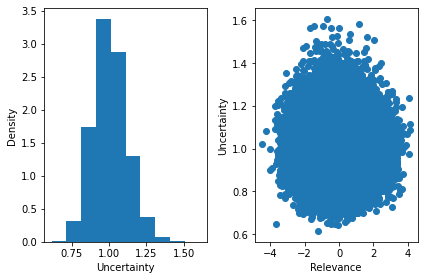

In [12]:
name = 'Pairwise'
def init_model(**kwargs):
    return Pairwise(baseline=mfpair, embedding_dim=128, **kwargs)

def objective(trial):
    
    # Parameter setup
    params = {'gamma': trial.suggest_float('gamma', 1e-5, 1e-2, log=True)}
    params_str = '-'.join(f'{key}={value}' for key, value in params.items())
    data.batch_size = int(base_batch_size / 2)
    print(params, data.batch_size)

    # Train
    model = init_model(**params)
    recall, path, train_likelihood = train(model, data, path='checkpoints/' + name, name=params_str, patience=patience)
    trial.set_user_attr('filename', path)
    trial.set_user_attr('mean_loss', train_likelihood)
    return recall

study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1]
model = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_uncertain(model, data, max_k=10, name=name)

clear_output(wait=True)
best_runs

# Joint MF models

,number,value,datetime_start,datetime_complete,duration,params_k,params_neg,params_ratio,params_wd,user_attrs_filename,user_attrs_mean_loss,state
39,39,0.114482,2023-01-30 02:19:49.559683,2023-01-30 02:27:35.933637,0 days 00:07:46.373954,29.0,2,0.3,0.000324,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,3.206300,COMPLETE
33,33,0.113882,2023-01-30 01:35:02.579423,2023-01-30 01:42:35.991558,0 days 00:07:33.412135,50.0,3,0.4,0.000736,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,3.597531,COMPLETE
30,30,0.113251,2023-01-30 01:02:53.481955,2023-01-30 01:13:43.442847,0 days 00:10:49.960892,41.0,1,0.4,0.000818,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,2.826674,COMPLETE
38,38,0.113082,2023-01-30 02:12:22.067960,2023-01-30 02:19:49.558961,0 days 00:07:27.491001,28.0,3,0.4,0.000478,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,4.617324,COMPLETE
34,34,0.112905,2023-01-30 01:42:35.992293,2023-01-30 01:50:04.399500,0 days 00:07:28.407207,51.0,3,0.4,0.000660,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,3.639900,COMPLETE
37,37,0.112782,2023-01-30 02:04:57.797194,2023-01-30 02:12:22.067260,0 days 00:07:24.270066,32.0,3,0.4,0.000498,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,4.373997,COMPLETE
32,32,0.112522,2023-01-30 01:26:50.026133,2023-01-30 01:35:02.578708,0 days 00:08:12.552575,43.0,3,0.5,0.000765,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,3.802762,COMPLETE
31,31,0.112509,2023-01-30 01:13:43.443550,2023-01-30 01:26:50.025410,0 days 00:13:06.581860,47.0,1,0.4,0.000812,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,2.872020,COMPLETE
35,35,0.112454,2023-01-30 01:50:04.400309,2023-01-30 01:57:32.434761,0 days 00:07:28.034452,48.0,5,0.3,0.000644,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,5.739207,COMPLETE
36,36,0.110616,2023-01-30 01:57:32.435462,2023-01-30 02:04:57.796489,0 days 00:07:25.361027,65.0,5,0.2,0.000367,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,4.734520,COMPLETE


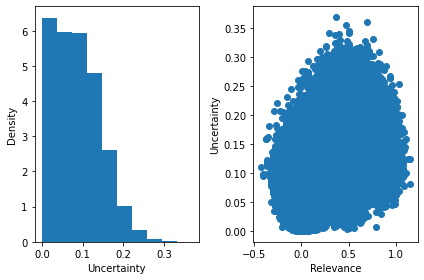

In [2]:
name = 'AUR-J'
def init_model(**kwargs):
    return DoubleMF(data.n_user, data.n_item, embedding_dim=128, embedding_dim_var=128, beta=1/2, gamma=0, loss='AUR', **kwargs)

def objective(trial):
    
    # Parameter setup
    params = {'weight_decay': trial.suggest_float('wd', 1e-4, 1e-1, log=True),
              'n_negatives': trial.suggest_int('neg', 1, 20),
              'ratio': trial.suggest_float('ratio', 0.2, 0.8, step=0.1),
              'k': trial.suggest_int('k', 1, 100)}
    params_str = '-'.join(f'{key}={value}' for key, value in params.items())
    data.batch_size = int(base_batch_size / (params['n_negatives'] + 1))
    print(params, data.batch_size)

    # Train
    model = init_model(**params)
    recall, path, train_likelihood = train(model, data, path='checkpoints/' + name, name=params_str, patience=patience)
    trial.set_user_attr('filename', path)
    trial.set_user_attr('mean_loss', train_likelihood)
    return recall

study = run_study(name, objective, n_trials=10)
best_runs = study.trials_dataframe().sort_values('value')[::-1]
model = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_uncertain(model, data, max_k=10, name=name)

clear_output(wait=True)
best_runs

,number,value,datetime_start,datetime_complete,duration,params_neg,params_wd,user_attrs_filename,user_attrs_mean_loss,state
16,16,0.119905,2023-01-29 04:22:42.435326,2023-01-29 04:32:28.597657,0 days 00:09:46.162331,5,0.000149,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.827039,COMPLETE
19,19,0.119154,2023-01-29 04:35:28.399934,2023-01-29 04:45:12.576048,0 days 00:09:44.176114,4,0.000215,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.809204,COMPLETE
12,12,0.118440,2023-01-29 03:43:57.164381,2023-01-29 03:53:38.932961,0 days 00:09:41.768580,4,0.000850,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.808865,COMPLETE
15,15,0.118078,2023-01-29 04:11:35.025396,2023-01-29 04:22:42.434693,0 days 00:11:07.409297,5,0.000108,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.831633,COMPLETE
14,14,0.117641,2023-01-29 04:01:56.708375,2023-01-29 04:11:35.024765,0 days 00:09:38.316390,4,0.000569,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.810930,COMPLETE
13,13,0.114322,2023-01-29 03:53:38.933608,2023-01-29 04:01:56.707688,0 days 00:08:17.774080,3,0.000516,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.785501,COMPLETE
6,6,0.100799,2023-01-28 14:05:14.117263,2023-01-28 14:11:36.569701,0 days 00:06:22.452438,1,0.012126,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.720926,COMPLETE
5,5,0.092828,2023-01-28 13:57:16.901537,2023-01-28 14:05:14.116714,0 days 00:07:57.215177,10,0.003611,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.869829,COMPLETE
11,11,0.084854,2023-01-29 03:40:08.989452,2023-01-29 03:43:57.163652,0 days 00:03:48.174200,2,0.000411,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.701194,COMPLETE
3,3,0.080240,2023-01-28 13:48:00.204592,2023-01-28 13:54:46.978510,0 days 00:06:46.773918,8,0.020942,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.843400,COMPLETE


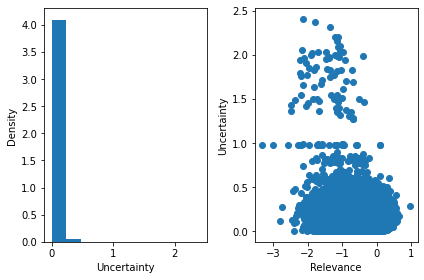

In [3]:
name = 'Pointwise-J'
def init_model(**kwargs):
    return DoubleMF(data.n_user, data.n_item, embedding_dim=128, embedding_dim_var=128, gamma=0, loss='Pointwise', **kwargs)

def objective(trial):
    
    # Parameter setup
    params = {'weight_decay': trial.suggest_float('wd', 1e-4, 1e-1, log=True),
              'n_negatives': trial.suggest_int('neg', 1, 20)}
    params_str = '-'.join(f'{key}={value}' for key, value in params.items())
    data.batch_size = int(base_batch_size / (params['n_negatives'] + 1))
    print(params, data.batch_size)

    # Train
    model = init_model(**params)
    recall, path, train_likelihood = train(model, data, path='checkpoints/' + name, name=params_str, patience=patience)
    trial.set_user_attr('filename', path)
    trial.set_user_attr('mean_loss', train_likelihood)
    return recall

study = run_study(name, objective, n_trials=10)
best_runs = study.trials_dataframe().sort_values('value')[::-1]
model = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_uncertain(model, data, max_k=10, name=name)

clear_output(wait=True)
best_runs

,number,value,datetime_start,datetime_complete,duration,params_wd,user_attrs_filename,user_attrs_mean_loss,state
6,6,0.072779,2023-01-29 04:53:37.262118,2023-01-29 04:56:38.739094,0 days 00:03:01.476976,0.003539,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.775002,COMPLETE
0,0,0.064896,2023-01-28 14:23:38.343188,2023-01-28 14:26:44.739304,0 days 00:03:06.396116,0.022276,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.752272,COMPLETE
14,14,0.064850,2023-01-29 05:06:47.598925,2023-01-29 05:08:35.116860,0 days 00:01:47.517935,0.008458,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.730584,COMPLETE
17,17,0.064536,2023-01-29 05:11:37.326129,2023-01-29 05:13:24.271098,0 days 00:01:46.944969,0.028309,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.720514,COMPLETE
2,2,0.064478,2023-01-29 04:47:37.916122,2023-01-29 04:49:24.998063,0 days 00:01:47.081941,0.000554,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.741083,COMPLETE
3,3,0.064472,2023-01-29 04:49:24.998699,2023-01-29 04:51:13.650658,0 days 00:01:48.651959,0.001008,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.741564,COMPLETE
19,19,0.064014,2023-01-29 05:14:34.147163,2023-01-29 05:16:22.525721,0 days 00:01:48.378558,0.003908,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.718305,COMPLETE
1,1,0.063906,2023-01-29 04:45:55.622396,2023-01-29 04:47:37.915622,0 days 00:01:42.293226,0.000127,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.746292,COMPLETE
7,7,0.063669,2023-01-29 04:56:38.739712,2023-01-29 04:58:26.273880,0 days 00:01:47.534168,0.002178,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.734969,COMPLETE
18,18,0.063499,2023-01-29 05:13:24.271710,2023-01-29 05:14:34.146596,0 days 00:01:09.874886,0.000304,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.723975,COMPLETE


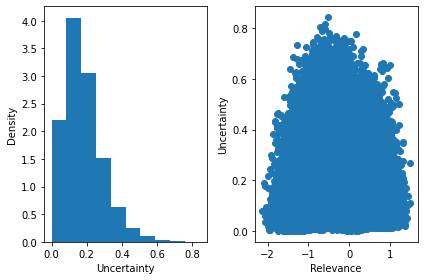

In [4]:
name = 'Pairwise-J'
def init_model(**kwargs):
    return DoubleMF(data.n_user, data.n_item, embedding_dim=128, embedding_dim_var=128, gamma=0, loss='Pairwise', **kwargs)

def objective(trial):
    
    # Parameter setup
    params = {'weight_decay': trial.suggest_float('wd', 1e-4, 1e-1, log=True)}
    params_str = '-'.join(f'{key}={value}' for key, value in params.items())
    data.batch_size = int(base_batch_size / 2)
    print(params, data.batch_size)

    # Train
    model = init_model(**params)
    recall, path, train_likelihood = train(model, data, path='checkpoints/' + name, name=params_str, patience=patience)
    trial.set_user_attr('filename', path)
    trial.set_user_attr('mean_loss', train_likelihood)
    return recall

study = run_study(name, objective, n_trials=19)
best_runs = study.trials_dataframe().sort_values('value')[::-1]
model = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_uncertain(model, data, max_k=10, name=name)

clear_output(wait=True)
best_runs

# MLP

# MLP Uncertain losses

[0.02433775 0.03708609 0.04471578 0.05034033 0.05364929 0.05633807
 0.05885889 0.06068446 0.06188178 0.06311084]


,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_dropout,params_lr,params_neg,user_attrs_filename,state
2,2,0.192346,2023-01-03 03:39:16.805675,2023-01-03 03:48:38.240323,0 days 00:09:21.434648,256,128,0.136499,0.000417,18,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
0,0,0.189641,2023-01-03 03:24:05.053427,2023-01-03 03:33:28.201862,0 days 00:09:23.148435,256,128,0.017215,0.000733,7,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
8,8,0.189365,2023-01-03 04:37:40.407437,2023-01-03 04:45:53.245816,0 days 00:08:12.838379,256,128,0.160747,0.000540,6,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
3,3,0.188703,2023-01-03 03:48:38.240982,2023-01-03 03:56:43.559042,0 days 00:08:05.318060,256,128,0.187313,0.000692,3,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
5,5,0.185444,2023-01-03 04:06:03.982330,2023-01-03 04:16:35.470852,0 days 00:10:31.488522,256,128,0.174982,0.000742,18,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE


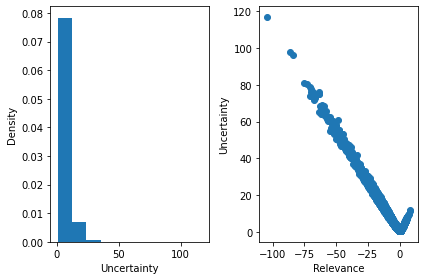

In [22]:
name = 'GaussianMLP-Pointwise'
def init_model(**kwargs):
    return GaussianMLP(data.n_user, data.n_item, loss='GBR', **kwargs)

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 256, 256)
    params = {'embedding_dim': trial.suggest_int('dim', 128, 128),
              'lr': trial.suggest_float('lr', 1e-5, 1e-3),
              'dropout': trial.suggest_float('dropout', 0, 0.2),
              'n_negatives': trial.suggest_int('neg', 1, 20)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str, patience=patience)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
model = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_uncertain(model, data, max_k=10, name=name)

clear_output(wait=True)
print(results['MAP'])
best_runs

[0.03096027 0.04536424 0.05346303 0.05863687 0.06263429 0.06561098
 0.06794877 0.06989672 0.07109156 0.07227623]


,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_dropout,params_lr,user_attrs_filename,state
5,5,0.195466,2023-01-03 05:44:05.204540,2023-01-03 05:58:00.719506,0 days 00:13:55.514966,256,128,0.144499,0.000154,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
3,3,0.190453,2023-01-03 05:23:31.437668,2023-01-03 05:34:56.261004,0 days 00:11:24.823336,256,128,0.156999,0.000446,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
2,2,0.190218,2023-01-03 05:10:53.433649,2023-01-03 05:23:31.436985,0 days 00:12:38.003336,256,128,0.086439,0.000376,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
1,1,0.189502,2023-01-03 05:01:43.133713,2023-01-03 05:10:53.432911,0 days 00:09:10.299198,256,128,0.147244,0.000387,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
9,9,0.189334,2023-01-03 06:29:19.580639,2023-01-03 06:36:15.471267,0 days 00:06:55.890628,256,128,0.041694,0.000985,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE


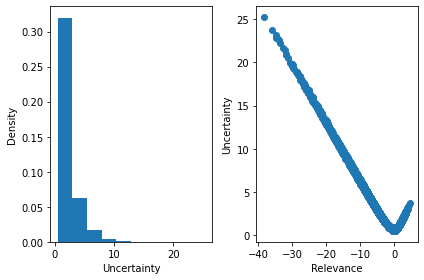

In [23]:
name = 'GaussianMLP-Pairwise'
def init_model(**kwargs):
    return GaussianMLP(data.n_user, data.n_item, loss='GPR', **kwargs)

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 256, 256)
    params = {'embedding_dim': trial.suggest_int('dim', 128, 128),
              'lr': trial.suggest_float('lr', 1e-5, 1e-3),
              'dropout': trial.suggest_float('dropout', 0, 0.2)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str, patience=patience)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
model = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_uncertain(model, data, max_k=10, name=name)

clear_output(wait=True)
print(results['MAP'])
best_runs

[0.02582781 0.03874172 0.04750276 0.05186258 0.05519315 0.05782837
 0.06027533 0.06211812 0.06335183 0.06430314]


,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_dropout,params_lr,params_neg,user_attrs_filename,state
1,1,0.170630,2023-01-03 15:51:04.635054,2023-01-03 15:58:13.202575,0 days 00:07:08.567521,256,128,0.131802,0.000526,6,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
8,8,0.169609,2023-01-03 16:42:08.281789,2023-01-03 16:48:09.448080,0 days 00:06:01.166291,256,128,0.189405,0.000596,8,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
4,4,0.169359,2023-01-03 16:12:20.153743,2023-01-03 16:22:19.324755,0 days 00:09:59.171012,256,128,0.057020,0.000513,9,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
7,7,0.168415,2023-01-03 16:36:09.992142,2023-01-03 16:42:08.281050,0 days 00:05:58.288908,256,128,0.120169,0.000035,11,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
5,5,0.167459,2023-01-03 16:22:19.325451,2023-01-03 16:30:10.314893,0 days 00:07:50.989442,256,128,0.199863,0.000665,17,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE


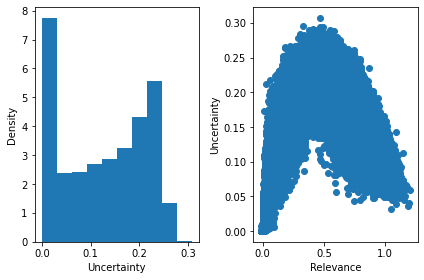

In [24]:
name = 'GaussianMLP-MSE'
def init_model(**kwargs):
    return GaussianMLP(data.n_user, data.n_item, loss='AUR', **kwargs)

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 256, 256)
    params = {'embedding_dim': trial.suggest_int('dim', 128, 128),
              'lr': trial.suggest_float('lr', 1e-5, 1e-3),
              'dropout': trial.suggest_float('dropout', 0, 0.2),
              'n_negatives': trial.suggest_int('neg', 1, 20)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str, patience=patience)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
model = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_uncertain(model, data, max_k=10, name=name)

clear_output(wait=True)
print(results['MAP'])
best_runs

# Results

In [31]:
# Load results
results = {}
for key in os.listdir('results'):
    results[key.replace('.pkl', '').replace('_', ' ')] = pickle.load(open(os.path.join('results', key), 'rb'))
order = ['MF-BPR', 'MF-BCE', 'MF-Pointwise', 'MF-Pairwise', 'MF-MSE', 
         'AUR', 'Pointwise', 'Pairwise',
         'AUR-J', 'Pointwise-J', 'Pairwise-J']
drop = ['MF-BPR', 'MF-BCE', 'MF-Pointwise', 'MF-Pairwise', 'MF-MSE']
results['Pairwise'] = results['Pairwise-J']
results = pd.DataFrame([results[key] for key in order], index=order)

# Plot aestetics
colors = [c for c in list(TABLEAU_COLORS)] + ['k', 'b', 'g', 'r', 'm']
colors = {k:c for k, c in zip(results.index, colors)}
lines = ['o', 'v', '^', '<', '>', 's', 'p', '+', 'x', '*', 'p']
lines = {k: '-' + l for k, l, in zip(results.index, lines)}

# Results
results[['FCP', 'URI', 'UAC']].T

,MF-BPR,MF-BCE,MF-Pointwise,MF-Pairwise,MF-MSE,AUR,Pointwise,Pairwise,AUR-J,Pointwise-J,Pairwise-J
FCP,0.859335,0.861309,0.858004,0.862595,0.82987,0.829870,0.858004,0.833409,0.862211,0.858434,0.833409
URI,NaN,NaN,NaN,NaN,NaN,-0.135854,-0.095585,0.098170,0.110391,0.150130,0.098170
UAC,NaN,NaN,NaN,NaN,NaN,0.253230,-0.234860,0.367384,0.258291,0.103275,0.367384


In [35]:
results

,FCP,MAP,Recall,Average_Surprise,corr_usup,corr_isup,norm_unc,UAC,URI,unc_MAP,MAP2,Recall2,Average_Surprise2,MAP-Uncertainty,Surprise-Uncertainty,MAP-ProfSize,Surprise-ProfSize
MF-BPR,0.859335,"[0.42433774, 0.5080298, 0.529622, 0.53274006, ...","[0.022043787, 0.04059602, 0.056239937, 0.07082...","[0.4404568860654718, 0.44330046547357815, 0.44...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MF-BCE,0.861309,"[0.47466886, 0.55248344, 0.57422733, 0.5761406...","[0.025330767, 0.04589023, 0.06437609, 0.080924...","[0.4469284831168661, 0.4503251485278611, 0.452...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MF-Pointwise,0.858004,"[0.45463577, 0.53451985, 0.55616724, 0.5582459...","[0.024959272, 0.044625085, 0.062515125, 0.0785...","[0.45522094832434734, 0.456922165111764, 0.458...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MF-Pairwise,0.862595,"[0.45380795, 0.52872515, 0.54823405, 0.5515268...","[0.022879524, 0.041387867, 0.05777047, 0.07267...","[0.4282734747192392, 0.43094065256074854, 0.43...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MF-MSE,0.829870,"[0.44701988, 0.5360099, 0.5576573, 0.56043506,...","[0.025805088, 0.046705183, 0.06547753, 0.08217...","[0.4614974991575451, 0.4651878932896936, 0.468...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AUR,0.829870,"[0.44701988, 0.5360099, 0.5576573, 0.56043506,...","[0.025805088, 0.046705183, 0.06547753, 0.08217...","[0.4614974991575451, 0.4651878932896936, 0.468...",0.137016,0.896030,"[[1.7333898544311523, 0.8324320912361145, -0.0...",0.253230,-0.135854,"[0.46992147, 0.48323494, 0.49513578, 0.5038374...","[0.44569537, 0.5366722, 0.56005794, 0.56311166...","[0.025677748, 0.047262512, 0.066239044, 0.0826...","[0.4618019790469685, 0.46548908270807615, 0.46...","[0.4309162497520447, 0.4363447427749634, 0.471...","[0.4920061165938274, 0.492004223213262, 0.4920...","[0.3565981984138489, 0.41129520535469055, 0.44...","[0.4012273648659946, 0.4362025204158503, 0.472..."
GBR,0.858004,"[0.45463577, 0.53451985, 0.55616724, 0.5582459...","[0.024959272, 0.044625085, 0.062515125, 0.0785...","[0.45522094832434734, 0.456922165111764, 0.458...",-0.394878,-0.221831,"[[0.5380602478981018, -0.3113116919994354, -0....",-0.234860,-0.095585,"[0.42939472, 0.4409997, 0.45550776, 0.4724329,...","[0.37748346, 0.4638245, 0.49230137, 0.49790752...","[0.020614166, 0.038762685, 0.05518073, 0.06995...","[0.4525448687565781, 0.4541878176414223, 0.455...","[0.5948264002799988, 0.5974081158638, 0.549333...","[0.46710496789470796, 0.4670982440028245, 0.46...","[0.32187309861183167, 0.3968502879142761, 0.45...","[0.3676801552147848, 0.4130602864502071, 0.461..."
GPR,0.833409,"[0.35728475, 0.42061257, 0.43973508, 0.4439155...","[0.015933067, 0.027725942, 0.038294498, 0.0478...","[0.35724475110042847, 0.3589398881629244, 0.36...",0.502196,-0.289519,"[[-0.5287303924560547, -0.5940230488777161, -1...",0.367384,0.098170,"[0.42057604, 0.42109478, 0.42152023, 0.4209974...","[0.3039735, 0.36514902, 0.38476822, 0.39052153...","[0.011886798, 0.021146895, 0.029389808, 0.0373...","[0.33533788115298657, 0.33721749300397713, 0.3...","[0.3127244710922241, 0.3088668882846832, 0.318...","[0.45155135214762077, 0.45155229179051254, 0.4...","[0.1927400529384613, 0.22591078281402588, 0.31...","[0.22392700099730956, 0.28082975167333474, 0.3..."
AUR-J,0.862211,"[0.4152318, 0.49470198, 0.51614237, 0.52130705...","[0.02049131, 0.038469754, 0.05524134, 0.069615...","[0.4561503356460305, 0.45770323547363856, 0.45...",0.155288,0.917812,"[[0.4865328371524811, 0.9900005459785461, -0.8...",0.258291,0.110391,"[0.5004434, 0.49899358, 0.49773407, 0.4961915,...","[0.36721855, 0.44346026, 0.46890178, 0.4763061...","[0.02007332, 0.03725745, 0.05238907, 0.0657906...","[0.444635046283963, 0.4462645774989856, 0.4475...","[0.424771249294281, 0.42096948623657227, 0.430...","[0.45682971403667033, 0.4568226147836895, 0.45...","[0.29803144931793213, 0.3561743497848511, 0.39...","[0.37461443533098077, 0.41367682698142005, 

In [43]:
results.rename(index={'AUR': 'AUR-S', 'Pointwise': 'GBR-S', 'Pairwise': 'GPR-S', 'Pointwise-J': 'GBR-J', 'Pairwise-J': 'GPR-J'}, inplace=True)
results.rename(index={'AUR-S': 'AUR', 'GBR-S': 'GBR', 'GPR-S':'GPR'}, inplace=True)
colors = [c for c in list(TABLEAU_COLORS)] + ['k', 'b', 'g', 'r', 'm']
colors = {k:c for k, c in zip(results.index, colors)}
lines = ['o', 'v', '^', '<', '>', 's', 'p', '+', 'x', '*', 'p']
lines = {k: '-' + l for k, l, in zip(results.index, lines)}
drop = ['MF-BPR', 'MF-Pointwise', 'MF-Pairwise', 'MF-MSE']

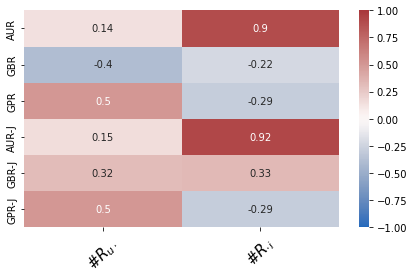

In [44]:
# Correlation plot
corr = results.drop(index=drop+['MF-BCE'])[['corr_usup', 'corr_isup']]
corr.columns=[r'#$R_{u\cdot}$', r'#$R_{\cdot i}$']
sns.heatmap(corr.round(3), annot=True, vmax=1, vmin=-1, center=0, cmap='vlag')
plt.xticks(rotation=45, fontsize=15)
plt.tight_layout()
plt.savefig('plots/corr.pdf')

,MAP,UA MAP,Recall,UA Recall,MAP-Improvement,Recall-Improvement
MF-BCE,0.533378,NaN,0.154780,NaN,nan%,nan%
AUR,0.518233,0.522056,0.158285,0.159596,0.738%,0.828%
GBR,0.519105,0.470184,0.152456,0.144104,-9.424%,-5.478%
GPR,0.420423,0.374771,0.094400,0.077880,-10.859%,-17.5%
AUR-J,0.491842,0.454672,0.139538,0.131796,-7.557%,-5.549%
GBR-J,0.461661,0.479779,0.133105,0.139055,3.924%,4.47%
GPR-J,0.420423,0.374771,0.094400,0.077880,-10.859%,-17.5%


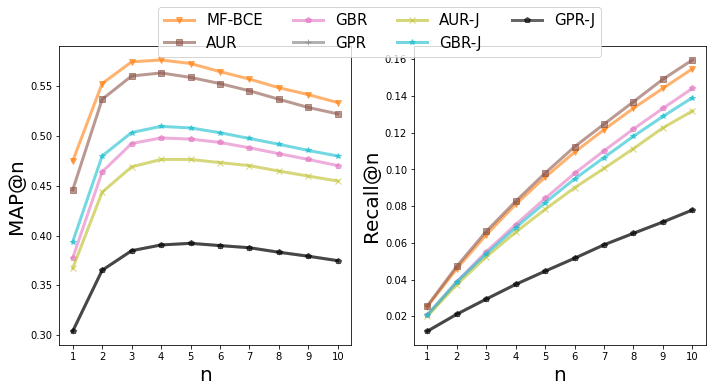

In [45]:
## Top-K accuracy metrics
f, ax = plt.subplots(figsize=(10, 5), ncols=2)
for index, row in results.drop(index=drop).iterrows():
    try:
        ax[0].plot(np.arange(1, 11), row['MAP2'], lines[index], color=colors[index], label=index, linewidth=3, alpha=0.6)
        ax[1].plot(np.arange(1, 11), row['Recall2'], lines[index], color=colors[index], label=index, linewidth=3, alpha=0.6)
    except:
        ax[0].plot(np.arange(1, 11), row['MAP'], lines[index], color=colors[index], label=index, linewidth=3, alpha=0.6)
        ax[1].plot(np.arange(1, 11), row['Recall'], lines[index], color=colors[index], label=index, linewidth=3, alpha=0.6)
ax[0].set_xticks(np.arange(1, 11))
ax[0].set_xlabel('n', fontsize=20)
ax[0].set_ylabel('MAP@n', fontsize=20)
ax[1].set_xticks(np.arange(1, 11))
ax[1].set_xlabel('n', fontsize=20)
ax[1].set_ylabel('Recall@n', fontsize=20)
handles, labels = ax[0].get_legend_handles_labels()
f.legend(handles, labels, fontsize=15, ncol=4, bbox_to_anchor=(0.85, 1.1))
f.tight_layout()
f.savefig('plots/accuracy.pdf', bbox_inches='tight')

table = results.drop(index=drop)[['MAP', 'MAP2', 'Recall', 'Recall2']].transform(lambda x: x.str[-1])
table.columns = ['MAP', 'UA MAP', 'Recall', 'UA Recall']
table['MAP-Improvement'] = (((table['UA MAP'] / table['MAP']) - 1) * 100).round(3).astype(str).add('%')
table['Recall-Improvement'] = (((table['UA Recall'] / table['Recall']) - 1) * 100).round(3).astype(str).add('%')
table.to_csv('plots/improvements.csv')
table

KeyError: 'AUR-S'

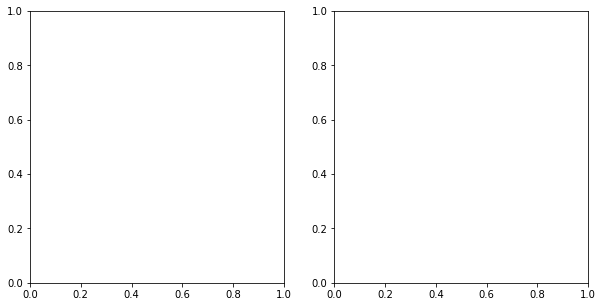

In [31]:
## MAP and Surprise vs Uncertainty
f, ax = plt.subplots(figsize=(10, 5), ncols=2, sharex=True)
x = np.arange(10) + 1
for index, row in results.drop(index=drop).iterrows():
    ax[0].plot(x, row['MAP-Uncertainty'], lines[index], color=colors[index], label=index, linewidth=3, alpha=0.6)
    ax[1].plot(x, row['MAP-ProfSize'], lines[index], color=colors[index], label=index, linewidth=3, alpha=0.6)
ax[0].set(xticks = x)
ax[0].set_xlabel('Uncertainty bin', fontsize=25)
ax[0].set_ylabel('MAP@10', fontsize=20)
ax[1].set_xlabel(r'User profile size bin', fontsize=25)
ax[1].set_ylabel('MAP@10', fontsize=20)
handles, labels = ax[0].get_legend_handles_labels()
f.legend(handles, labels, fontsize=15, ncol=2, bbox_to_anchor=(0.83, 1.15))
f.tight_layout()
f.savefig('plots/MAP-Uncertainty.pdf')